# VGG
-----

### Set Up
-----

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import joblib
import math
import sns


/Users/simybasra/anaconda3/envs/my_img_env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

In [49]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']

### Utility Functions


In [4]:
def img_resize(X_data, new_height, new_width, rgb= True):

    # reshape to force X_data to have 4 dimenstions
    X_data = X_data.reshape(X_data.shape[0],X_data.shape[1],X_data.shape[2],-1)

    if rgb == True:
        # force X  to have three channels (RGB)
        X_rgb = np.repeat(X_data, 3, axis=-1) 
    else:
        pass

    # each image stored as single item in list
    resized_images = []
    for i in range(X_rgb.shape[0]):
        resized_image = tf.image.resize(X_rgb[i], size=[new_height,new_width])
        resized_images.append(resized_image)   
    
    # combines list of tensor items to single tensor item new dimenstion = num of images in list 
    X_resized = tf.stack(resized_images)
    
    return X_resized

### Setting up VGG 16

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16

In [5]:
y = joblib.load( '../../model/my_files/y.pkl' )

In [6]:
num_output_classes = len(np.unique(y))

In [7]:
my_vgg = keras.applications.VGG16(include_top=False, # Set to false to only load the conv layers, will be swapping out the top layers for ownß
                                     weights='imagenet', 
                                     input_tensor=None,
                                     input_shape=(32,32,3), # changing input shape to (32,32,3) 32 is minimium size
                                     pooling=max, # for my output will use pooling
                                     classes= num_output_classes, # setting to len of my y (24)
                                     classifier_activation='softmax' # keep as softmax for output layer
                                 )


In [8]:
my_vgg.trainable = False # freezing weights was I am using weights from imagenet so they are not refreshed 

In [9]:
my_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

### Adding my own top layers

In [10]:
my_model = Sequential([my_vgg,
                       layers.Flatten(),
                       layers.Dense(128, activation='relu'),
                       layers.Dense(64, activation="relu"),
                       layers.Dense(num_output_classes, activation="softmax")
                       ])



In [11]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
Total params: 14,790,168
Trainable params: 75,480
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

### Testing the model with augmented data as it is

In [12]:
X_aug = joblib.load( '../../model/my_files/X_train_aug.pkl')
y_aug = joblib.load( '../../model/my_files/y_train_aug.pkl')


In [13]:
all_images = []

# Iterate over each array in X_aug
for batch in X_aug:
    # Iterate over each image in the batch
    for image in batch:
        # Append the image to the list of all images
        all_images.append(image)

# Convert the list of images to a NumPy array
all_images_array = np.array(all_images)

In [16]:
all_class = []

# Iterate over each array in X_aug
for batch in y_aug:
    # Iterate over each image in the batch
    for c in batch:
        # Append the image to the list of all images
        all_class.append(c)

# Convert the list of images to a NumPy array
all_class_array = np.array(all_class)

In [17]:
all_images_array.shape

(27701, 28, 28, 1)

In [121]:
all_class_array.shape

(27701,)

In [122]:
X = all_images_array.reshape(-1,28,28)
y = all_class_array

In [123]:
# Sanity Check 
X.shape

(27701, 28, 28)

In [140]:
X_resized = img_resize(X, 32, 32, rgb= True)
X_resized.shape

TensorShape([27701, 32, 32, 3])

In [141]:
vgg_pred = my_model.predict(X_resized)

593/866 [===================>..........] - ETA: 22s

KeyboardInterrupt: 

In [ ]:
score = my_model.evaluate(X_resized, y, verbose=1)

1083/1083 [==============================] - 78s 71ms/step - loss: 28.9604 - accuracy: 0.0448


In [ ]:
score[1]

0.044849395751953125

### Train model using the original MNIST data

In [56]:
X = joblib.load( '../../model/my_files/X.pkl')
y = joblib.load( '../../model/my_files/y.pkl')

In [57]:
X.shape

(34627, 784)

In [58]:
y.shape

(34627,)

In [59]:
X = X.reshape(-1,28,28)
X.shape

(34627, 28, 28)

In [60]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [61]:
X_train_resized = img_resize(X_train, 32, 32)
X_val_resized = img_resize(X_val, 32, 32)

In [19]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [20]:
history = my_model.fit(X_train_resized, y_train,
                        batch_size = 128,
                        epochs = 20,
                        verbose = 1,
                        validation_split = 0.2,
                        callbacks=[early_stop])

Epoch 1/20


2024-07-01 12:03:30.486282: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


174/174 [==============================] - 68s 388ms/step - loss: 1.3873 - accuracy: 0.7165 - val_loss: 0.1557 - val_accuracy: 0.9626
Epoch 2/20
174/174 [==============================] - 84s 480ms/step - loss: 0.0751 - accuracy: 0.9848 - val_loss: 0.0432 - val_accuracy: 0.9913
Epoch 3/20
174/174 [==============================] - 87s 500ms/step - loss: 0.0232 - accuracy: 0.9973 - val_loss: 0.0206 - val_accuracy: 0.9962
Epoch 4/20
174/174 [==============================] - 73s 423ms/step - loss: 0.0095 - accuracy: 0.9995 - val_loss: 0.0108 - val_accuracy: 0.9987
Epoch 5/20
174/174 [==============================] - 76s 436ms/step - loss: 0.0049 - accuracy: 0.9999 - val_loss: 0.0077 - val_accuracy: 0.9989
Epoch 6/20
174/174 [==============================] - 78s 448ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 0.9993
Epoch 7/20
174/174 [==============================] - 74s 426ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 0.9

In [23]:
my_model.save('../../model/my_files/my_VGG_model.h5')

In [21]:
train_loss, train_acc = my_model.evaluate(X_train_resized, y_train)
print('Train accuracy:', train_acc)

866/866 [==============================] - 74s 85ms/step - loss: 4.5179e-04 - accuracy: 0.9999
Train accuracy: 0.9998916983604431


In [22]:
# Evaluate the model's performance
val_loss, val_acc= my_model.evaluate(X_val_resized, y_val, verbose=1)
print('Test accuracy:', val_acc)

217/217 [==============================] - 18s 83ms/step - loss: 0.0033 - accuracy: 0.9991
Test accuracy: 0.9991337060928345


### Model Performance

In [62]:
my_model = load_model('../../model/my_files/my_VGG_model.h5')

In [63]:
unique_values = np.unique(y_val)

217/217 [==============================] - 17s 79ms/step


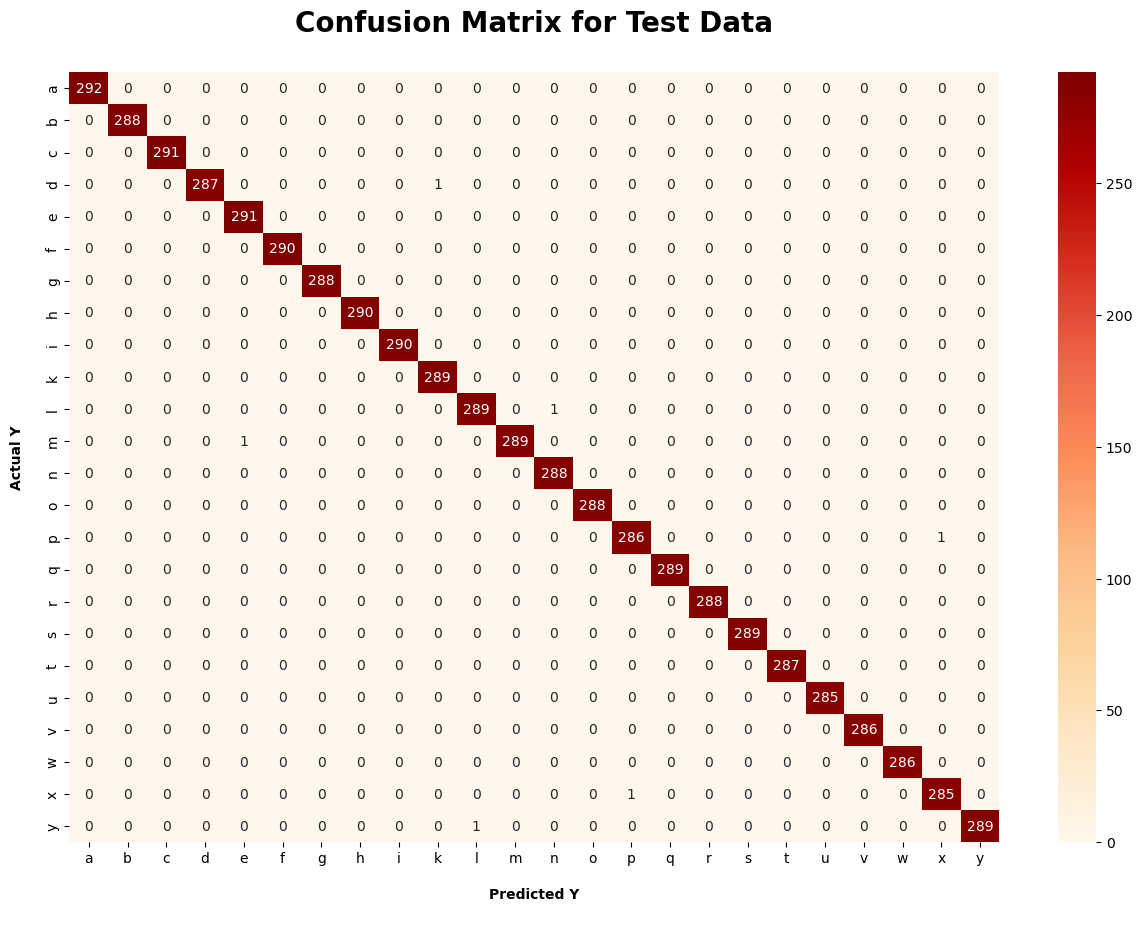

In [64]:
pred_y = np.argmax(my_model.predict(X_val_resized), axis=1)
# Calculating the confusion matrix using sklearn.metrics
conf_matrix = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Test Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

### Visualising Misclassifications

In [65]:
incorrect_photos = (y_val != pred_y)

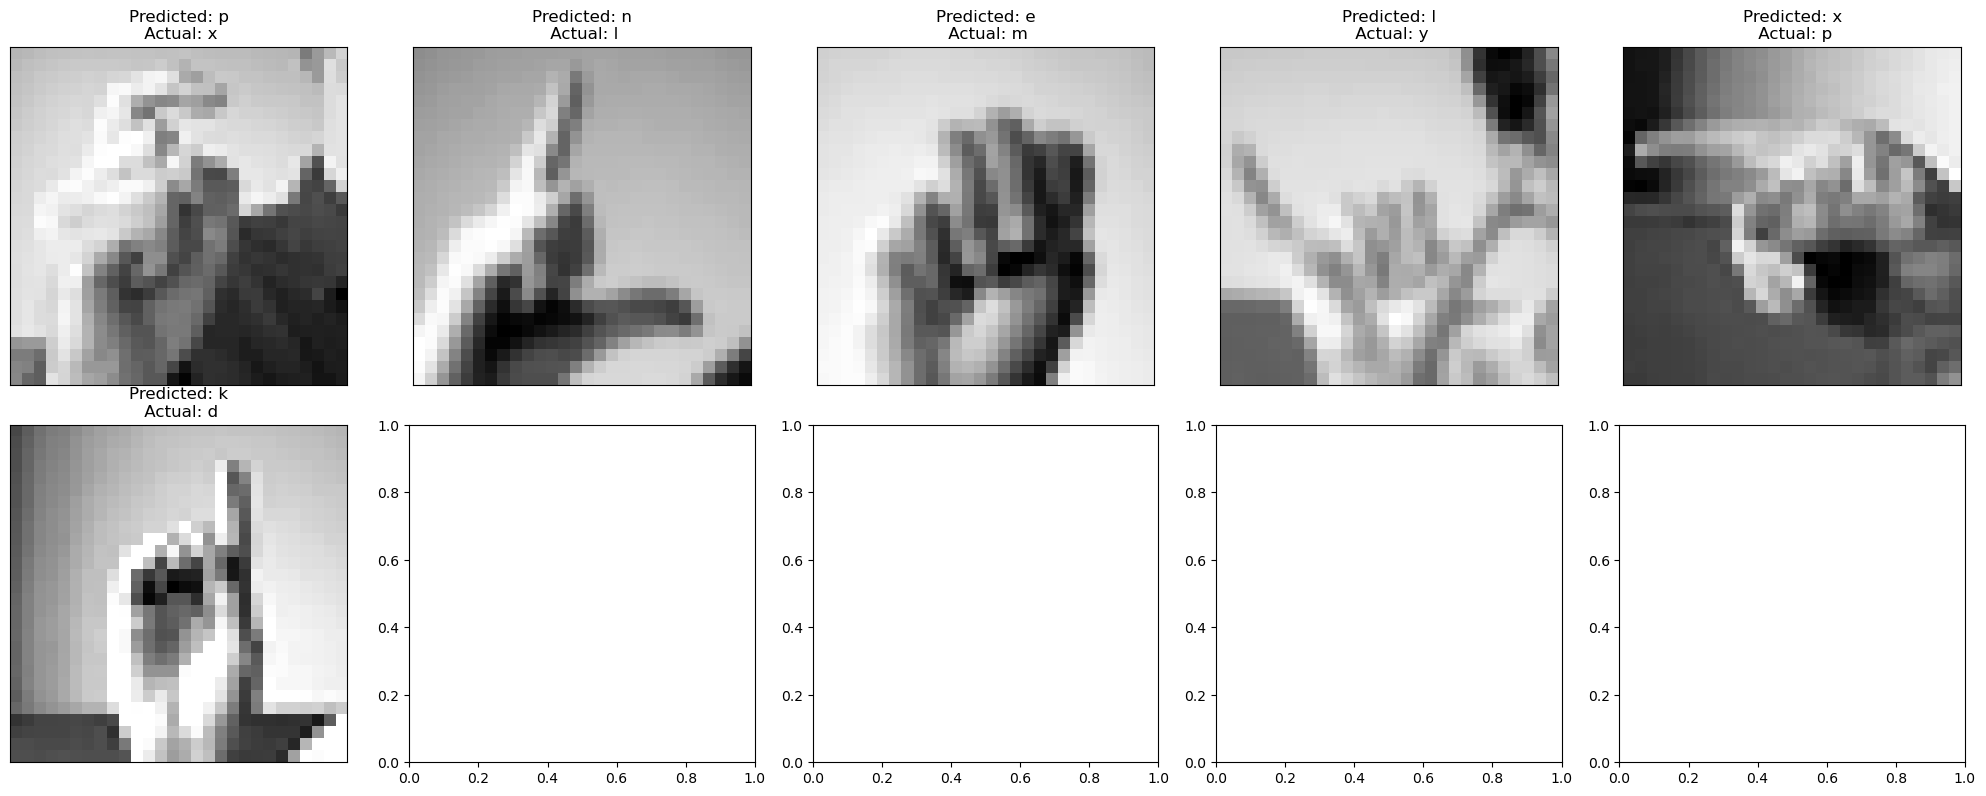

In [69]:
num_photos = incorrect_photos.sum()
rows = math.ceil(num_photos/5)

fig, axes = plt.subplots(rows,5, figsize=(20,4*rows))

ax = axes.flatten()

for i, image in enumerate(X_val[incorrect_photos]):
    ax[i].imshow(image, cmap='gray')

    # Get predicted label
    p = pred_y[incorrect_photos][i]
    prediction = alphabet[p]

    # Get actual label
    t = y_val[incorrect_photos][i]
    actual = alphabet[t.astype(np.int32)]

    # Set the title of the subplot
    ax[i].set_title(f"Predicted: {prediction}\n Actual: {actual}")

    # Hide the x and y ticks to make
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()


### Testing VGG model using augmented data

In [30]:
X_aug = joblib.load( '../../model/my_files/X_train_aug.pkl')
y_aug = joblib.load( '../../model/my_files/y_train_aug.pkl')


In [37]:
all_images = []

# Iterate over each array in X_aug
for batch in X_aug:
    # Iterate over each image in the batch
    for image in batch:
        # Append the image to the list of all images
        all_images.append(image)

# Convert the list of images to a NumPy array
all_images_array = np.array(all_images)

In [38]:
all_class = []

# Iterate over each array in X_aug
for batch in y_aug:
    # Iterate over each image in the batch
    for c in batch:
        # Append the image to the list of all images
        all_class.append(c)

# Convert the list of images to a NumPy array
all_class_array = np.array(all_class)

In [39]:
all_images_array.shape

(27701, 28, 28, 1)

In [40]:
# Convert the list of images to a NumPy array
all_class_array.shape

(27701,)

In [41]:
X_aug = all_images_array.reshape(-1,28,28)
y_aug = all_class_array
print(f'X aug shape {X_aug.shape}')
print(f'y aug shape {y_aug.shape}')

X aug shape (27701, 28, 28)
y aug shape (27701,)


In [42]:
X_aug_resized = img_resize(X_aug, 32,32)
print(f'X aug new shape {X_aug_resized.shape}')

X aug new shape (27701, 32, 32, 3)


In [43]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [44]:
history = my_model.fit(X_aug_resized, y_aug,
                        batch_size = 128,
                        epochs = 10,
                        verbose = 1,
                        validation_split = 0.2,
                        callbacks=[early_stop])

Epoch 1/10
174/174 [==============================] - 57s 326ms/step - loss: 1.8637 - accuracy: 0.4098 - val_loss: 1.4233 - val_accuracy: 0.5226
Epoch 2/10
174/174 [==============================] - 73s 422ms/step - loss: 1.2787 - accuracy: 0.5714 - val_loss: 1.2123 - val_accuracy: 0.5929
Epoch 3/10
174/174 [==============================] - 118s 680ms/step - loss: 1.1107 - accuracy: 0.6256 - val_loss: 1.0996 - val_accuracy: 0.6261
Epoch 4/10
174/174 [==============================] - 139s 800ms/step - loss: 1.0060 - accuracy: 0.6653 - val_loss: 0.9863 - val_accuracy: 0.6688
Epoch 5/10
174/174 [==============================] - 84s 483ms/step - loss: 0.9273 - accuracy: 0.6907 - val_loss: 0.9410 - val_accuracy: 0.6827
Epoch 6/10
174/174 [==============================] - 78s 450ms/step - loss: 0.8649 - accuracy: 0.7092 - val_loss: 0.8811 - val_accuracy: 0.6979
Epoch 7/10
174/174 [==============================] - 78s 448ms/step - loss: 0.8120 - accuracy: 0.7264 - val_loss: 0.9041 - val_

In [45]:
my_model.save('../../model/my_files/my_VGG_model_AUG.h5')

In [46]:
aug_val_loss, aug_val_acc = my_model.evaluate(X_val_resized, y_val) # testing on normal dataset
print('Test accuracy:', aug_val_acc)

217/217 [==============================] - 17s 77ms/step - loss: 50.7970 - accuracy: 0.3737
Test accuracy: 0.3736644387245178


## Data Augmentation
-----

In [24]:
my_model = load_model('../../model/my_files/my_VGG_model.h5')

In [25]:
train_datagen = joblib.load('../../model/my_files/train_datagen.pkl') 
val_datagen = joblib.load('../../model/my_files/val_datagen.pkl') 

In [26]:
train_generator = train_datagen.flow(X_train_resized, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_resized, y_val, batch_size=32)

In [27]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [28]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [29]:
my_model.fit(train_generator,
              steps_per_epoch=len(train_generator),
              epochs=20,
              validation_data=val_generator,
              validation_steps=len(val_generator),
              callbacks=[early_stop]
    )

Epoch 1/20
866/866 [==============================] - 75s 87ms/step - loss: 1.3831 - accuracy: 0.5566 - val_loss: 0.6505 - val_accuracy: 0.7791
Epoch 2/20
866/866 [==============================] - 78s 90ms/step - loss: 0.8416 - accuracy: 0.7173 - val_loss: 0.4337 - val_accuracy: 0.8618
Epoch 3/20
866/866 [==============================] - 86s 100ms/step - loss: 0.6974 - accuracy: 0.7599 - val_loss: 0.3453 - val_accuracy: 0.8852
Epoch 4/20
866/866 [==============================] - 93s 107ms/step - loss: 0.6069 - accuracy: 0.7933 - val_loss: 0.2569 - val_accuracy: 0.9255
Epoch 5/20
866/866 [==============================] - 91s 105ms/step - loss: 0.5545 - accuracy: 0.8077 - val_loss: 0.2845 - val_accuracy: 0.9131
Epoch 6/20
866/866 [==============================] - 92s 106ms/step - loss: 0.4853 - accuracy: 0.8344 - val_loss: 0.1994 - val_accuracy: 0.9427
Epoch 7/20
866/866 [==============================] - 90s 104ms/step - loss: 0.4570 - accuracy: 0.8437 - val_loss: 0.1880 - val_accu

In [30]:
my_model.save('../../model/my_files/my_VGG_model_AUG.h5')

In [31]:
train_loss, train_acc = my_model.evaluate(train_generator)
print('Train accuracy:', train_acc)

866/866 [==============================] - 57s 66ms/step - loss: 0.2365 - accuracy: 0.9192
Train accuracy: 0.9192447662353516


In [32]:
val_loss, val_acc = my_model.evaluate(val_generator)
print('Test accuracy:', val_acc)

217/217 [==============================] - 15s 67ms/step - loss: 0.0681 - accuracy: 0.9805
Test accuracy: 0.9805082082748413


## Top Up Training using Teachable Machine
----

https://keras.io/guides/transfer_learning/

In [92]:
# load the base VGG model
base_vgg_model = load_model('../../model/my_files/my_VGG_model.h5')

In [93]:
# unfreeze the base model weights
base_vgg_model.trainable = True

In [94]:
# recompile the model
base_vgg_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

### Get data from TM - should I try augment the dat before top up training?

In [5]:
directory = '../../model/tm_images/'
my_imgs = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(32, 32),
    shuffle=True, 
    seed=1
)

Found 2970 files belonging to 24 classes.


In [6]:
train_data, val_data = keras.utils.split_dataset(my_imgs, right_size= 0.2)

2024-07-01 18:47:16.948176: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [97]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [98]:
history = base_vgg_model.fit( train_data,
                        batch_size = 128,
                        epochs = 20,
                        verbose = 1,
                        validation_data = val_data,
                        callbacks=[early_stop])

Epoch 1/20


75/75 [==============================] - 23s 300ms/step - loss: 5.2015 - accuracy: 0.0442 - val_loss: 3.2058 - val_accuracy: 0.0438
Epoch 2/20
75/75 [==============================] - 22s 294ms/step - loss: 3.1914 - accuracy: 0.0438 - val_loss: 3.1945 - val_accuracy: 0.0320
Epoch 3/20
75/75 [==============================] - 22s 299ms/step - loss: 3.0338 - accuracy: 0.0812 - val_loss: 2.6081 - val_accuracy: 0.1902
Epoch 4/20
75/75 [==============================] - 23s 302ms/step - loss: 2.2577 - accuracy: 0.2336 - val_loss: 1.7568 - val_accuracy: 0.3822
Epoch 5/20
75/75 [==============================] - 23s 309ms/step - loss: 1.3211 - accuracy: 0.5008 - val_loss: 1.1525 - val_accuracy: 0.5808
Epoch 6/20
75/75 [==============================] - 25s 328ms/step - loss: 0.8865 - accuracy: 0.6587 - val_loss: 0.9157 - val_accuracy: 0.7222
Epoch 7/20
75/75 [==============================] - 24s 320ms/step - loss: 0.5467 - accuracy: 0.8030 - val_loss: 0.4265 - val_accuracy: 0.8418
Epoch 8/20

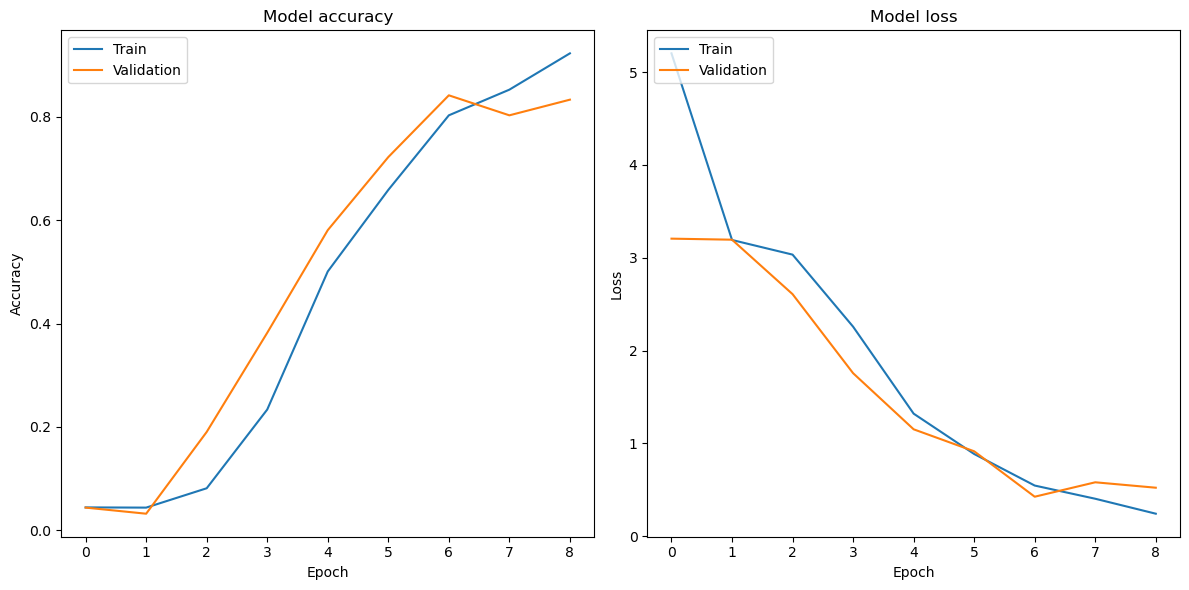

In [99]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# epochs 18

In [100]:
train_loss, train_acc= base_vgg_model.evaluate(train_data)
print('Train accuracy:', train_acc)

75/75 [==============================] - 5s 64ms/step - loss: 0.4716 - accuracy: 0.8695
Train accuracy: 0.869528591632843


In [101]:
val_loss, val_acc= base_vgg_model.evaluate(val_data)
print('Test accuracy:', val_acc)

19/19 [==============================] - 1s 62ms/step - loss: 0.5234 - accuracy: 0.8333
Test accuracy: 0.8333333134651184


In [102]:
base_vgg_model.save('../../model/my_files/top_up_VGG.h5')

In [13]:
base_vgg_model =load_model('../../model/my_files/top_up_VGG.h5')

## Model Performance

### Confusion Matrix

In [32]:
pred_y = np.argmax(base_vgg_model.predict(val_data), axis=1)

19/19 [==============================] - 1s 74ms/step


In [33]:
pred_y.shape

(594,)

In [34]:
val_labels = []
for img, label in val_data:
    val_labels.append(label.numpy())

In [35]:
val_labels = np.concatenate(val_labels)

In [39]:
val_labels.shape

(594,)

In [38]:
pred_y.shape

(594,)

In [46]:
import seaborn as sns

In [47]:
unique_values = np.unique(val_labels)
unique_values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int32)

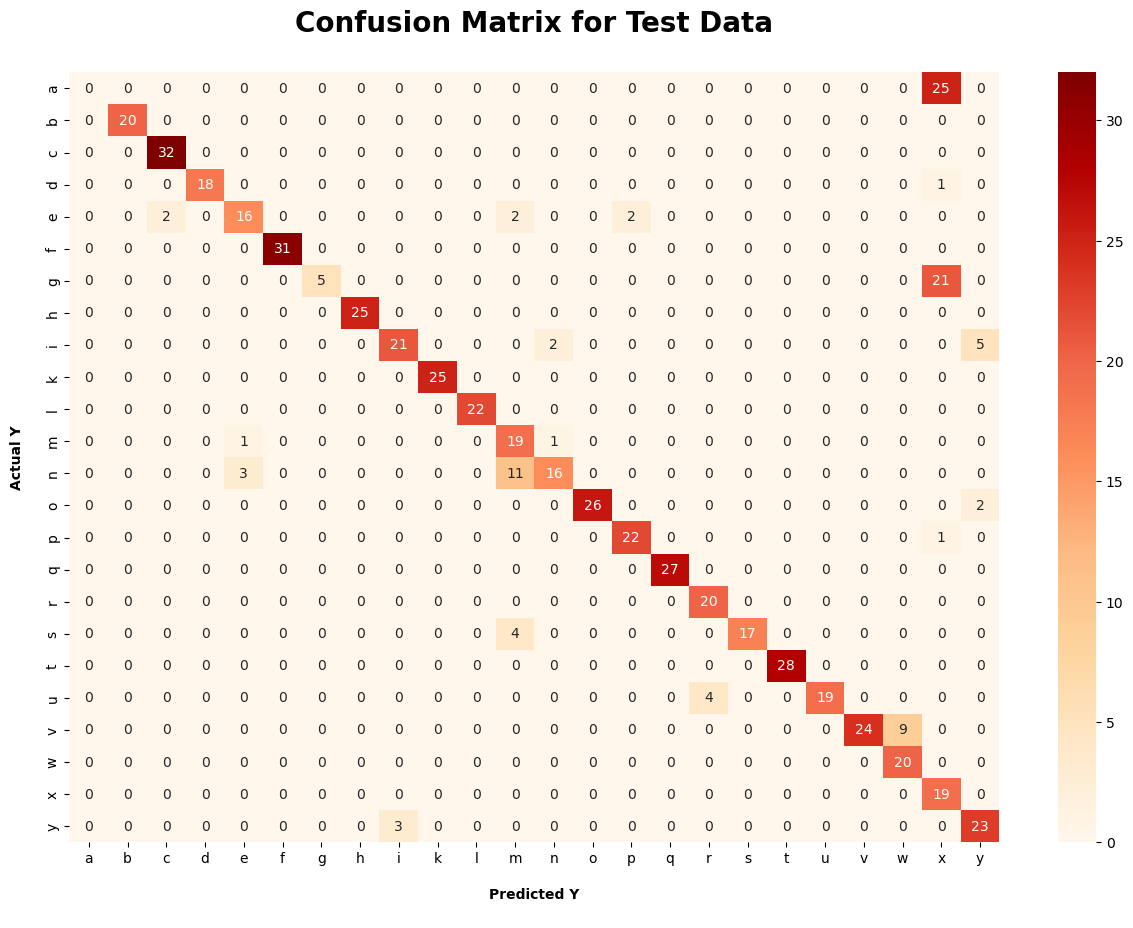

In [50]:
# Calculating the confusion matrix using sklearn.metrics
conf_matrix = confusion_matrix(val_labels, pred_y)

plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Test Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

### Visualising Misclassifications

In [ ]:
X_val

In [52]:
incorrect_photos = (val_labels != pred_y)

NameError: name 'X_val' is not defined

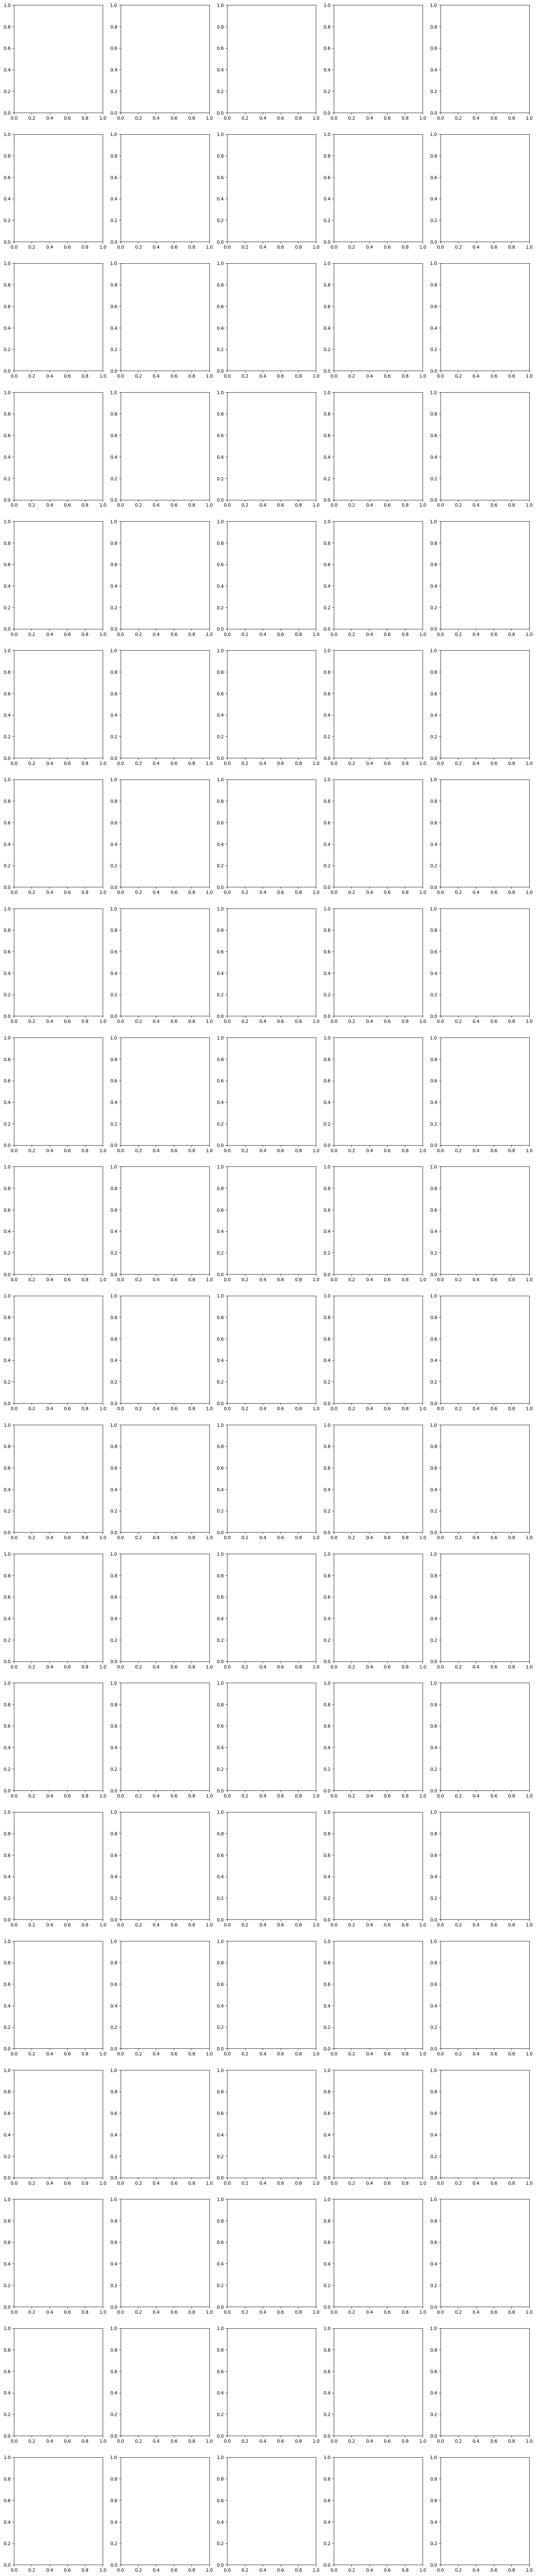

In [54]:
num_photos = incorrect_photos.sum()
rows = math.ceil(num_photos/5)

fig, axes = plt.subplots(rows,5, figsize=(20, 100))

ax = axes.flatten()

for i, image in enumerate(X_val[incorrect_photos]):
    ax[i].imshow(image, cmap='gray')

    # Get predicted label
    p = pred_y[incorrect_photos][i]
    prediction = alphabet[p]

    # Get actual label
    t = val_labels[incorrect_photos][i]
    actual = alphabet[t.astype(np.int32)]

    # Set the title of the subplot
    ax[i].set_title(f"Predicted: {prediction}\n Actual: {actual}")

    # Hide the x and y ticks to make
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()


In [56]:
ßtop_up = load_model('../../model/my_files/top_up_VGG.h5')

In [57]:
top_up.evaluate(train_data)

75/75 [==============================] - 5s 64ms/step - loss: 6.0396e-05 - accuracy: 1.0000


[6.039566869731061e-05, 1.0]

In [58]:
top_up.evaluate(val_data)

19/19 [==============================] - 1s 63ms/step - loss: 3.1048e-04 - accuracy: 1.0000


[0.0003104759962297976, 1.0]